#EP4 - CNN

Iniciando com a importação da bibliotecas:

In [ ]:
import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import datasets, transforms

dir_data = "~/temp"

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb_test,
    shuffle=True,
)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()

        # Camada convolucional, seguida de ReLU e Pooling
        # Entra uma imagem 28x28. Com filtro 5x5, padding de 2
        # e stride 1, a saída também tem 28x28. Após o pooling,
        # a saída fica com 14x14. A entrada tem 1 canal e a
        # saída tem 16.
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # Camada convolucional
        # Entrada 14x14, saída 7x7 após o pooling.
        # 16 canais de entrada e 32 de saída.
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Camada totalmente conectada
        # Na entrada, há 32 canais de 7x7 elementos
        # e a saída tem 10 neurônios.
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # Aplica primeira camada convolucional
        x = self.conv1(x)

        # Aplica segunda camada convolucional
        x = self.conv2(x)

        # Transforma os tensores 32x7x7 em
        # vetores para serem usados na entrada da
        # camada totalmente conectada. Vale notar
        # que a primeira dimensão dos tensores de
        # dados é usada para representar os diversos
        # elementos de um batch, por isso permanece
        # inalterada.
        x = x.view(x.size(0), -1)

        # Calcula a saída e retorna
        output = self.out(x)
        return output

In [ ]:
def cnn(eta, Nb, Nb_test, Ne, train_loader, test_loader):

  plt.figure(figsize=(16, 6))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      image, _ = train_loader.dataset.__getitem__(i)
      plt.imshow(image.squeeze().numpy())
      plt.axis('off');

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Instanciando modelo
  model = Model().to(device)

  # Função custo para treinamento
  loss_function = nn.CrossEntropyLoss()

  # Otimizador
  optimizer = torch.optim.Adam(model.parameters(), lr = eta)

    # Lista usada para guardar o valor da função custo ao longo das iterações
  losses = []

  # Loop das épocas
  for epoch in range(Ne):
      # Loop dos mini batches
      for n, (X, d) in enumerate(train_loader):
          # Envia os dados para a GPU, caso ela exista
          X = X.to(device=device)
          d = d.to(device=device)

          # Ajuste de dimensões
          # (elementos do mini batch x 1 canal x 28 x 28)
          X = X.view(-1, 1, 28, 28)

          # Coloca o modelo em modo treinamento
          model.train()

          # Zera informações de gradientes
          model.zero_grad()

          # Calcula a saída
          y = model(X)

          # Calcula o valor da função custo
          loss = loss_function(y, d)

          # Calcula os gradientes
          loss.backward()

          # Atualiza os pesos do modelo
          optimizer.step()

          # Armazena o valor da função custo
          losses.append(loss.item())

          # Mostra o valor da função custo a cada 100 iterações
          if n % 100 == 0:
              N_all = len(train_loader.dataset)
              n_ex = n * len(X)
              p = 100. * n / len(train_loader)
              print(
                  f"Época: {epoch} [{n_ex}/{N_all} ({p:.0f}%)]\tLoss: {loss:.6f}"
              )

  plt.figure()
  plt.plot(losses)
  plt.xlabel("Batch")
  plt.ylabel("Loss")

    # Variável usada para contabilizar o número de acertos
  correct = 0

  # Loop dos mini batches
  for n, (X, d) in enumerate(test_loader):
      # Envia os dados para a GPU, caso ela exista
      X = X.to(device=device)
      d = d.to(device=device)

      # Ajuste de dimensões
      X = X.view(-1, 1, 28, 28)

      # Coloca o modelo em modo de inferência
      model.eval()

      # Calcula a saída
      y = model(X)

      # Cálculo do número de acertos:
      # 1) Obtém o índice do elemento máximo para cada exemplo do minibatch
      pred = torch.max(y, 1, keepdim=True)[1]
      # 2) Conta o número de acertos e acumula na variável correct
      # pred.eq(d.view_as(pred)) é um tensor booleano. Dessa forma, o número de
      # acertos é obtido somando seus elementos. Valores True são tratados como 1.
      correct += pred.eq(d.view_as(pred)).cpu().sum().item()

  # Mostra o desempenho obtido no teste
  accuracy = 100. * correct / len(test_loader.dataset)
  print(f"Acurácia: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")

Avaliando modelo com os dados de teste:

Época: 0 [0/60000 (0%)]	Loss: 2.304235
Época: 0 [6400/60000 (11%)]	Loss: 0.455445
Época: 0 [12800/60000 (21%)]	Loss: 0.642132
Época: 0 [19200/60000 (32%)]	Loss: 0.280353
Época: 0 [25600/60000 (43%)]	Loss: 0.234585
Época: 0 [32000/60000 (53%)]	Loss: 0.282970
Época: 0 [38400/60000 (64%)]	Loss: 0.655820
Época: 0 [44800/60000 (75%)]	Loss: 0.370400
Época: 0 [51200/60000 (85%)]	Loss: 0.548859
Época: 0 [57600/60000 (96%)]	Loss: 0.264330
Época: 1 [0/60000 (0%)]	Loss: 0.363758
Época: 1 [6400/60000 (11%)]	Loss: 0.568210
Época: 1 [12800/60000 (21%)]	Loss: 0.467625
Época: 1 [19200/60000 (32%)]	Loss: 0.330827
Época: 1 [25600/60000 (43%)]	Loss: 0.438767
Época: 1 [32000/60000 (53%)]	Loss: 0.484693
Época: 1 [38400/60000 (64%)]	Loss: 0.130801
Época: 1 [44800/60000 (75%)]	Loss: 0.368169
Época: 1 [51200/60000 (85%)]	Loss: 0.324026
Época: 1 [57600/60000 (96%)]	Loss: 0.199112
Época: 2 [0/60000 (0%)]	Loss: 0.126390
Época: 2 [6400/60000 (11%)]	Loss: 0.179829
Época: 2 [12800/60000 (21%)]	Loss: 0.156698
Época:

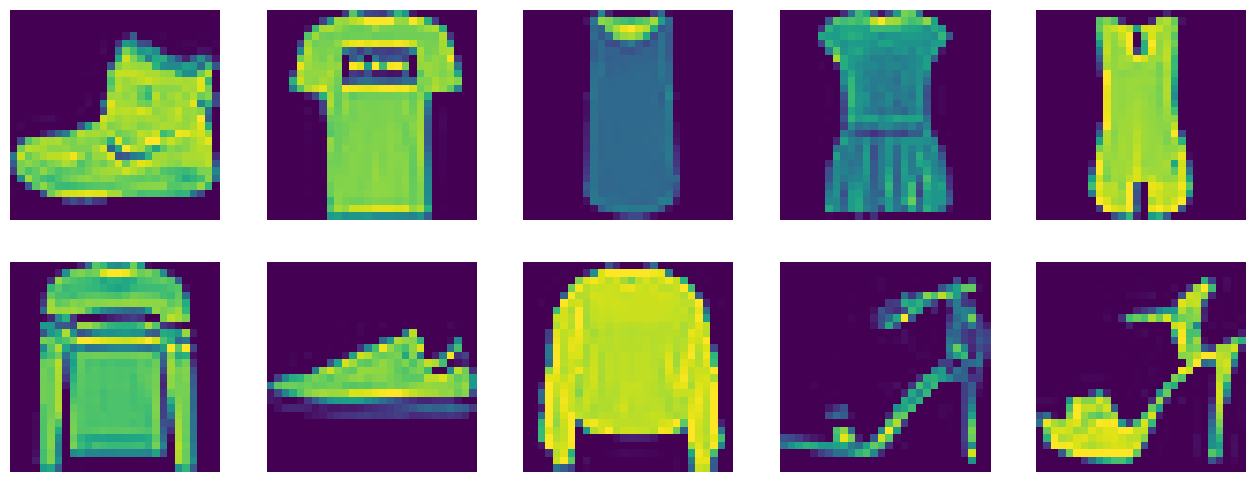

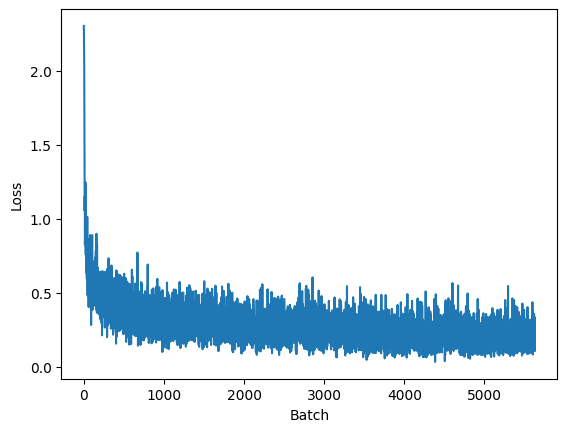

In [ ]:
# Ajuste de hiperparâmetros

eta = 0.0020       # passo de adaptação
Nb = 16            # Tamanho do mini-batch
Nb_test = 1000     # Tamanho do mini-batch usado no teste
Ne = 6             # Número de épocas

cnn(eta, Nb, Nb_test, Ne, train_loader, test_loader)